### RADS 602 Data Mining and Machine Learning 
- **Parin Kittipongdaja**
- **RADS 6136454 RADS/M**
- Conduct ML experiment

# Install Neccessary Library

In [1]:
import sys
!{sys.executable} -m pip install -U pandas matplotlib scikit-learn seaborn tqdm

Requirement already up-to-date: pandas in /anaconda3/envs/RAMA/lib/python3.7/site-packages (0.24.1)
Requirement already up-to-date: matplotlib in /anaconda3/envs/RAMA/lib/python3.7/site-packages (3.0.3)
Requirement already up-to-date: scikit-learn in /anaconda3/envs/RAMA/lib/python3.7/site-packages (0.20.3)
Requirement already up-to-date: seaborn in /anaconda3/envs/RAMA/lib/python3.7/site-packages (0.9.0)
Requirement already up-to-date: tqdm in /anaconda3/envs/RAMA/lib/python3.7/site-packages (4.31.1)
You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Check Version of Library

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import sklearn
import tqdm

print ( "Python", sys.version )
print ( "Numpy", np.__version__ )
print ( "Pandas", pd.__version__ )
print ( "Matplotlib", matplotlib.__version__ )
print ( "Scikit Learn", sklearn.__version__ )
print ( "tqdm", tqdm.__version__ )


Python 3.7.1 (default, Oct 23 2018, 14:07:42) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy 1.16.1
Pandas 0.24.1
Matplotlib 3.0.3
Scikit Learn 0.20.3
tqdm 4.31.1


# Importing Required Libraries

In [3]:
# Basic library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from itertools import cycle
from tqdm import tqdm

# Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# Tuning and Develop Model
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy.stats import randint as sp_randint
import scipy as sp

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


# Create function for conducting ML experiment

## Five Basic Function

In [4]:
def initialize(df):                           # Split data into feature and class(Target)
    X = df.iloc[:,:-1].values                 # Include only value of feature 
    y = df.iloc[:,-1].values                  # Include only value of class
    return X,y

def standardize(X):
    Xstd =StandardScaler().fit_transform(X)   # Standardize feature value 
    return Xstd

def split(X,y):                               # Split data to train and test
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.20, random_state=7, stratify=y)
    return X_trn, X_tst, y_trn, y_tst

def down_sampling(df):                        # Undersampling majority class to equal minority class
    X, y = initialize(df)                     # Reducing the frequency of majority class
    X_resampled, y_resampled = RandomUnderSampler(random_state=7).fit_resample(X, y)
    return df_us

def over_sampling(X,y):                       # Increasing the frequency of minority class 
    X_resampled, y_resampled = SMOTE(random_state=7).fit_resample(X, y)
    return X_resampled, y_resampled


## Additional Function

In [5]:
def split_2(X,y):                              # Same as split but add print summary of data for see shape
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.20, random_state=7, stratify=y)
    print("Size of training data is " + str(X_trn.shape))
    print("Size of training label is " + str(y_trn.shape))
    print("Size of testing data is " + str(X_tst.shape))
    print("Size of testing label is " + str(y_tst.shape))
    unique, counts = np.unique(y, return_counts=True)
    print('Class Counts:',np.asarray((unique, counts)).T.ravel())
    return X_trn, X_tst, y_trn, y_tst

def down_sampling_2(X,y):                      # Same as down_sampling but change type of input for practical use
    rus = RandomUnderSampler(random_state=7)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled

def up_sampling_2(X,y):                        # In case of we want to oversampling after do undersampling 
    df_Xus = pd.DataFrame(data = X)            # due to normal oversampling cannot perform with balanced data
    df_yus = pd.DataFrame(data = y)
    concat_df = pd.concat([df_Xus, df_yus], axis = 1)   # To concatenate data into df

    df_up = resample(concat_df,
                    replace=True,              # Sample with replacement
                    n_samples=df.shape[0],     # To match number of original data
                    random_state=7)            # Reproducible results

    X_f, y_f = initialize(df_up)               # From basic function to split df to (X, y)
    X_final, y_final = over_sampling(X_f, y_f) # From basic function to balance class
    return X_final, y_final

## Development Function

In [6]:
# Naive Bayes
def NB_HPTune(X, y, verbose = 0):
    gnb = GaussianNB(priors=None)
    param_dist = dict(var_smoothing = np.logspace(-16,0,200) ) # default is 1e-9
    rs = RandomizedSearchCV(estimator=gnb,
                             param_distributions=param_dist,
                             scoring='average_precision',
                             refit=True,
                             n_iter = 20,
                             cv=10,
                             n_jobs=-1,
                             random_state=7,
                             iid=True)
    if verbose == 1:
        start = time()    
        rs.fit(X, y)
        print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings." 
              % (time() - start, len(rs.cv_results_['params'])))
    elif verbose == 0:
        rs.fit(X, y)
    
    # Best parameter from RandomizedSearchCV
    bs_var_sm = rs.best_params_['var_smoothing']
    bs_var_sm_pw = np.log10(bs_var_sm)
    
    param_grid = dict(var_smoothing = np.logspace(bs_var_sm_pw*0.9,bs_var_sm_pw*1.1,50))
    gs = GridSearchCV(estimator=gnb, 
                      param_grid=param_grid,
                      scoring='average_precision',
                      refit=True,
                      cv=10,
                      n_jobs=-1, 
                      iid=True)
    
    if verbose == 1:
        start = time()
        gs.fit(X, y)
        print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
              % (time() - start, len(gs.cv_results_['params'])))
    elif verbose == 0:
        gs.fit(X, y)
    
    return rs, gs

# Decision Tree
def DT_HPTune(X, y, verbose = 0):
    n_fea = X.shape[1]
    dt = DecisionTreeClassifier(splitter='best')
    param_dist = dict(criterion =  ['gini', 'entropy'],
                      max_depth =  np.arange(3,15,1),
                      min_samples_split = np.linspace(0.1, 1.0, 20, endpoint=True)
                     )
    rs = RandomizedSearchCV(estimator=dt,
                             param_distributions=param_dist,
                             scoring='average_precision',
                             refit=True,
                             n_iter = 20,
                             cv=10,
                             n_jobs=-1,
                             random_state=7,
                             iid=True,
                             )
    if verbose == 1:
        start = time()    
        rs.fit(X, y)
        print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings." 
              % (time() - start, len(rs.cv_results_['params'])))
    elif verbose == 0:
        rs.fit(X, y)
        
    
    # Best parameter from RandomizedSearchCV
    bs_cri = rs.best_params_['criterion']
    bs_md = rs.best_params_['max_depth']
    bs_mss = rs.best_params_['min_samples_split']
    param_grid = dict(criterion =  [bs_cri],
                      max_depth =  np.arange(bs_md-2,bs_md+2,1),
                      min_samples_split = np.linspace(bs_mss*0.8, bs_mss*1.2, 20, endpoint=True)
                     )
    gs = GridSearchCV(estimator=dt, 
                      param_grid=param_grid,
                      scoring='average_precision',
                      refit=True,
                      cv=10,
                      n_jobs=-1,
                      iid=True
                      )
    if verbose == 1:
        start = time()
        gs.fit(X, y)
        print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
              % (time() - start, len(gs.cv_results_['params'])))
    elif verbose == 0:
        gs.fit(X, y)
    
    return rs, gs

# Support vector Machine
def SVM_HPTune(X, y, verbose = 0):
    svm = SVC(probability=True)
    param_dist = dict(C = sp.stats.expon(scale=10),
                      gamma = sp.stats.expon(scale=0.1),
                      kernel = ['sigmoid', 'rbf'],
                      decision_function_shape = ('ovo','ovr'))
    
    rs = RandomizedSearchCV(estimator=svm,
                             param_distributions=param_dist,
                             scoring='average_precision',
                             refit=True,
                             n_iter = 20,
                             cv=10,
                             random_state=7,
                             n_jobs=-1, 
                             iid=True,
                           )
    if verbose == 1:
        start = time()    
        rs.fit(X, y)
        print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings." 
              % (time() - start, len(rs.cv_results_['params'])))
    elif verbose == 0:
        rs.fit(X, y)
    
    # Best parameter from RandomizedSearchCV
    bs_C = rs.best_params_['C'] 
    bs_dfs = rs.best_params_['decision_function_shape'] 
    bs_gamma = rs.best_params_['gamma'] 
    bs_kernel = rs.best_params_['kernel'] 
    d_C = np.log10(bs_C)
    d_gamma = np.log10(bs_gamma)
    
    svm = SVC(probability=True)
    param_grid = dict(C = np.logspace(d_C-2,d_C+2,num=10),
                      gamma = np.logspace(d_gamma-2,d_gamma+2,num=10),
                      kernel = [bs_kernel],
                      decision_function_shape = [bs_dfs])
    gs = GridSearchCV(estimator=svm, 
                      param_grid=param_grid,
                      scoring='average_precision',
                      refit=True,
                      cv=10,
                      n_jobs=-1, 
                      iid=True,
                     )
    if verbose == 1:
        start = time()
        gs.fit(X, y)
        print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
              % (time() - start, len(gs.cv_results_['params'])))
    elif verbose == 0:
        gs.fit(X, y)
    
    return rs, gs

## Evaluation and Report Function

In [7]:
# Plot ROC Curve
def plot_roc(X_test, y_test, GridSearchCV_List):
    
    # Define cycol for iteration color
    from itertools import cycle
    cycol = cycle('bgrcmyk')
    cycol2 = cycle('bgrcmyk')
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for i in GridSearchCV_List:
        
        ax.set_title('ROC curve of experiment:'+ i[-5:-3])
        P_true = eval(i+'.predict_proba(X_test)[:, 1]')
        fpr, tpr, thresholds = roc_curve(y_test, P_true, pos_label=1)
        auc = round(roc_auc_score(y_test, P_true), 2)

        ax.plot(fpr, tpr, color=next(cycol), label=i[:-3]+", auc=" + str(auc))
        ax.fill_between(fpr, 0, tpr, color=next(cycol2), alpha=0.2)
        ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linestyle=':',linewidth=1.5)
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_xlim(left=0, right=1)
        ax.set_ylim(bottom=0, top=1)
        plt.legend(loc="best")
    
    plt.show()    

# Plot PR Curve 
def plot_pr(X_test, y_test, GridSearchCV_List):
    
    # Define color for iteration color
    from itertools import cycle
    cycol = cycle('bgrcmyk')
    cycol2 = cycle('bgrcmyk')
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for i in GridSearchCV_List:
        
        ax.set_title('PR curve of experiment:'+ i[-5:-3])
        P_true = eval(i+'.predict_proba(X_test)[:, 1]')
        ap = round(average_precision_score(y_test, P_true), 2)
        precision, recall, thresholds = precision_recall_curve(y_test, P_true, pos_label=1)
        
        ax.plot(recall, precision, color=next(cycol), label=i[:-3]+", average precision=" + str(ap))
        ax.fill_between(recall, 0, precision, color=next(cycol2), alpha=0.2)
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_xlim(left=0, right=1)
        ax.set_ylim(bottom=0, top=1)
        plt.legend(loc="best")

    plt.show()    


# Make a model summary report
def model_report(X_test,y_test,GridSearchCV_List):

    model_list = []
    experiment_list = []
    accuracy_list = []
    auc_list = []
    cm_list = []
    recall_list = []
    precision_list = []
    ap_list = []
    f1_list = []
    best_params_list = []
    
    for i in GridSearchCV_List:
        
        model_name = i[:-5]
        exp_name = i[-5:-3]
        y_pred = eval(i+'.best_estimator_.predict(X_test)')
        P_true = eval(i+'.predict_proba(X_test)[:, 1]')
        TP, FN, FP, TN = confusion_matrix(y_test, y_pred, labels=[1, 0]).ravel()
        
        Accuracy = round(accuracy_score(y_test, y_pred), 2)
        auc = round(roc_auc_score(y_test, P_true), 2)
        cm = dict(TP=TP, FP=FP, FN=FN, TN=TN)
        Recall = round(recall_score(y_test, y_pred, average='binary'), 2)
        Precision = round(precision_score(y_test, y_pred, average='binary'), 2)
        ap = round(average_precision_score(y_test, P_true), 2)
        F1_score = round(f1_score(y_test, y_pred,average='binary'), 2)
        best_params = eval(i+'.best_params_')
        
        model_list.append(model_name)
        experiment_list.append(exp_name)
        accuracy_list.append(Accuracy)
        auc_list.append(auc)
        cm_list.append(cm)
        recall_list.append(Recall)
        precision_list.append(Precision)
        ap_list.append(ap)
        f1_list.append(F1_score)
        best_params_list.append(best_params)
        

    report = dict(Model = model_list,
                  Experiment = experiment_list,
                  Accuracy = accuracy_list,
                  AUC = auc_list,
                  Confusion_Matrix = cm_list,
                  Recall = recall_list,
                  Precision = precision_list,
                  Average_Precision = ap_list,
                  F1_score = f1_list,
                  Best_Parameters = best_params_list )
    
    df_report = pd.DataFrame.from_dict(report)
    pd.set_option('display.max_colwidth', -1)
    
    return df_report

# 1. Importing Required Libraries
- (Already import from above)

# 2. Importing the Dataset
- Supervised learning datasets.
- Datasets about Type-2 diabetes from hyperglycemia patients.
- File name is 'sim_predm_parin.csv'

In [8]:
df = pd.read_csv('./data/sim_predm_parin.csv', delimiter=',', header=0,
                 names=['age','glu','hdl', 'ldl', 'bmi', 'dm'],
                 dtype={'age':'float',
                        'glu':'float',
                        'hdl':'float',
                        'ldl':'float',
                        'bmi':'float',
                        'dm':'str'
                        })
# Store name of column
df_col = df.columns.tolist()

# Encoding class data to [0,1]
df['dm'] = df['dm'].map({'yes': 1, 'no': 0})

# 3. Data Exploration

In [9]:
# For looking at first five row and last five row of dataset
df.head().append(df.tail())

,age,glu,hdl,ldl,bmi,dm
0,38.0,118.0,36.0,166.0,21.0,1
1,50.0,96.0,53.0,103.0,23.0,1
2,71.0,110.0,35.0,150.0,30.0,1
3,50.0,113.0,57.0,229.0,30.0,1
4,46.0,109.0,39.0,154.0,23.0,1
420,45.0,104.0,49.0,148.0,25.0,0
421,36.0,104.0,45.0,164.0,27.0,0
422,40.0,106.0,51.0,176.0,26.0,0
423,56.0,102.0,64.0,67.0,21.0,0
424,43.0,103.0,46.0,84.0,23.0,0


In [10]:
# See the column data types and non-missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 6 columns):
age    425 non-null float64
glu    425 non-null float64
hdl    425 non-null float64
ldl    425 non-null float64
bmi    425 non-null float64
dm     425 non-null int64
dtypes: float64(5), int64(1)
memory usage: 20.0 KB


In [11]:
# Check missing values in the dataset 
df.isnull().sum() 

age    0
glu    0
hdl    0
ldl    0
bmi    0
dm     0
dtype: int64

In [12]:
# Summary detail of data
df.describe()

,age,glu,hdl,ldl,bmi,dm
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,43.185882,104.007059,46.472941,147.896471,25.117647,0.167059
std,6.741927,7.469905,9.573935,37.979061,3.735386,0.373468
min,26.000000,85.000000,21.000000,49.000000,12.000000,0.000000
25%,38.000000,99.000000,40.000000,123.000000,23.000000,0.000000
50%,43.000000,104.000000,46.000000,149.000000,25.000000,0.000000
75%,48.000000,109.000000,52.000000,171.000000,27.000000,0.000000
max,71.000000,125.000000,76.000000,251.000000,36.000000,1.000000


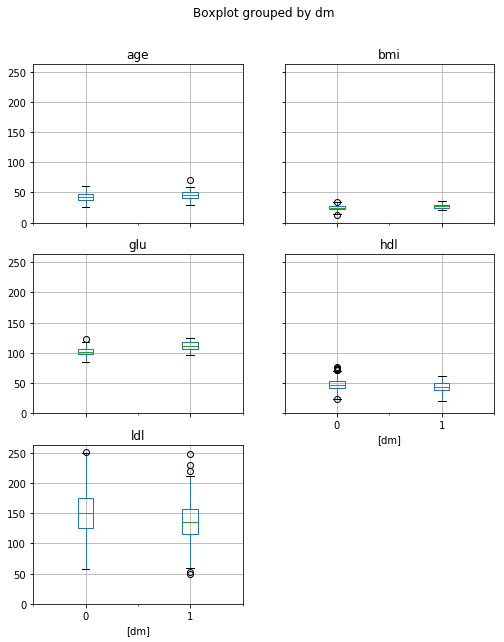

In [13]:
boxplot = df.boxplot(by="dm", figsize=(8, 10))

#### <font size="4" color='blue'>Model seletion</font>

- **Naive Bayes**</font>
    - There are three available models in the Sklearn python library:
        - *Gaussian*: It assumes that continuous features follow a normal distribution.
        - *Multinomial*: It is useful if your features are discrete.
        - *Bernoulli*: The binomial model is useful if your features are binary.
    - Due to our feature is numerical value, thus, we will implement a classic Gaussian Naive Bayes on the sim_predm dataset.
- **Decision tree**
- **Support Vector Machine**</font>

### Univariate analysis

/anaconda3/envs/RAMA/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/envs/RAMA/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/envs/RAMA/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


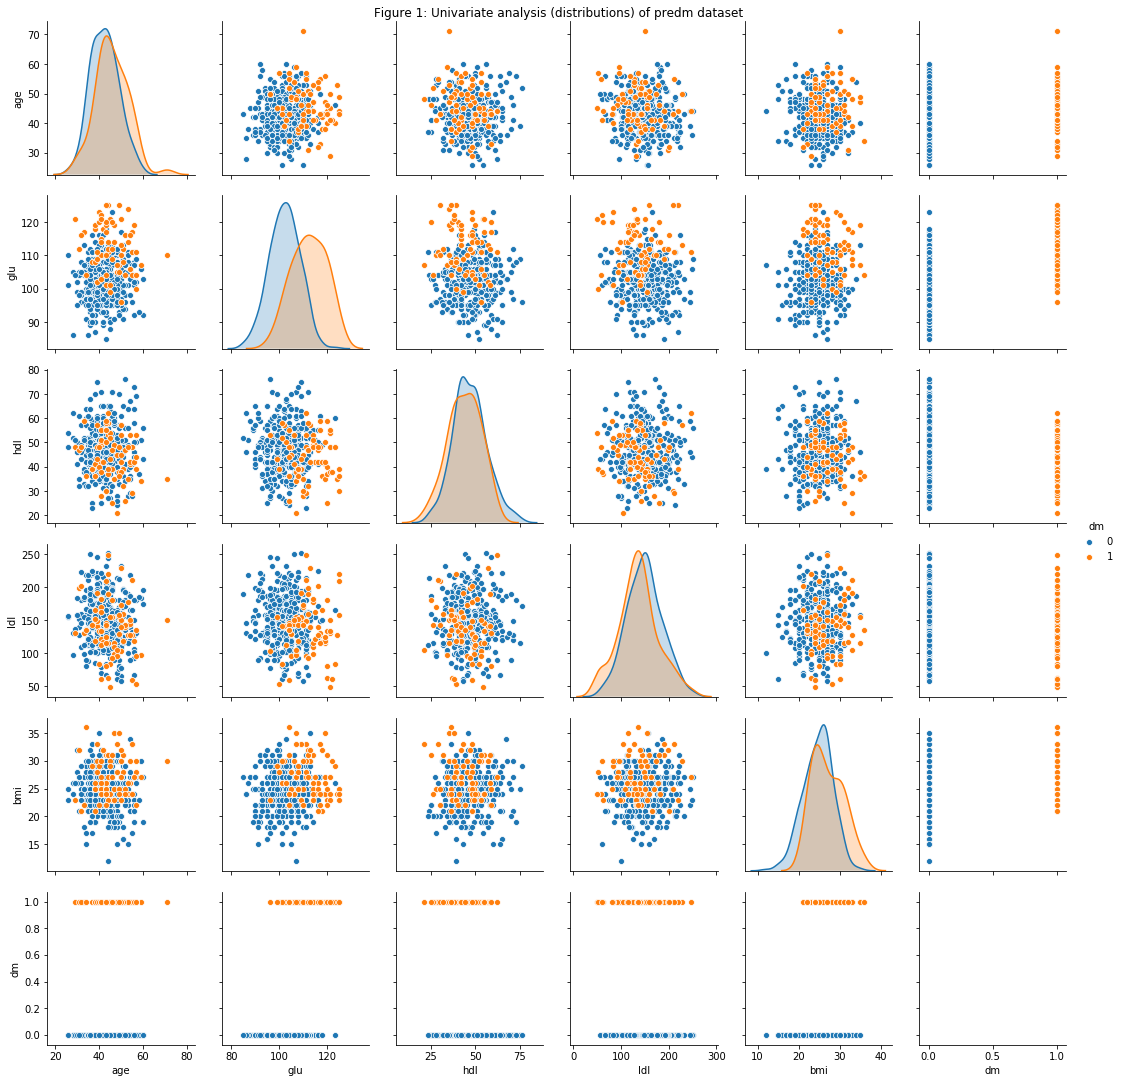

In [14]:
g = sns.pairplot(df, hue="dm")
g.fig.suptitle("Figure 1: Univariate analysis (distributions) of predm dataset", y = 1.0);

0    354
1     71
Name: dm, dtype: int64


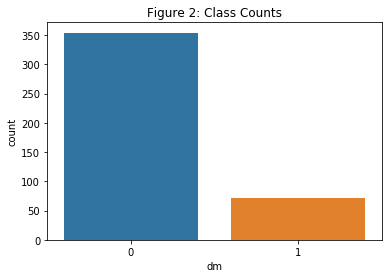

In [15]:
sns.countplot(df['dm']).set_title('Figure 2: Class Counts');
print(df['dm'].value_counts())

<font size="4" color='blue'>**According to Figure 1&2, we can see that the number of data in 'dm' or target variable is imbalance (Figure 2) that could be an issue when we develop model, hence, we should do under/over sampling to eliminate this issue. For data distribution by feature in each class arrange almost same location (Figure 1) except 'glu' look clearly seperate from the other. We can look for correlation in Pearson Correlation Matrix to explore more.**</font>

### Pearson Correlation Matrix
- It is a measure of the linear correlation between two variables X and Y.
- It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation

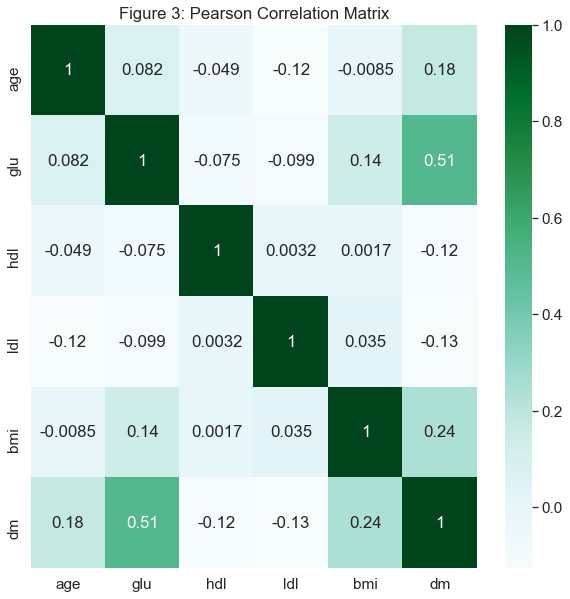

In [16]:
plt.figure(figsize=(10,10)) 
sns.set(font_scale=1.4)
plt.title('Figure 3: Pearson Correlation Matrix')
sns.heatmap(df.corr(), annot=True, cmap='BuGn')

<font size="4" color='blue'>**According to Figure 3, we can see that 'glu' and 'dm' has highest correlation which mean 'glu' might be the most important feature to classify DM disease from non-DM. And for another pair we don't see any pair has high value of correlation. Thus, we can conclude that there are no issue about multicolinearity and we do not need to do feature elimination(feature selection).**</font>

# 4. Data preprocessing
- Prepare the data
- Split data to feature and class(target)
- Scaling the data (Standardize)
- Do under sampling or over sampling or both
- Split data to train and test

## Define pipeline (Experiment)

In [1]:
# Definition
a = 'Initialize'
b = 'Standardize'
c = 'Split'
d = 'Down_sampling'
e = 'Over_sampling'
Develop = 'Develop_Model'

# Experiment
aa = 'a->b->c->Develop'
bb = 'a->c->Develop'
cc = 'a->d->c->Develop'
dd = 'a->e->c->Develop'
ee = 'a->d->e->c->Develop'
ff = 'a->d->b->c->Develop'
gg = 'a->e->b->c->Develop'
hh = 'a->d->e->b->c->Develop'

In [2]:
# List all experiment and model
Pipe_list = ['aa','bb','cc','dd','ee','ff','gg','hh']
Model_list = ['NB_HPTune', 'DT_HPTune', 'SVM_HPTune']

In [3]:
# To describe pipeline(experiment)
def describe_pipe(pipe):
    print((' --> ').join(list(map(eval,pipe.split('->')))))  

## Prepare Experiment Data

### aa

In [20]:
describe_pipe(aa)

Initialize --> Standardize --> Split --> Develop_Model


In [21]:
Xaa, yaa = initialize(df)
Xaa_std = standardize(Xaa)
Xaa_trn, Xaa_tst, yaa_trn, yaa_tst = split_2(Xaa_std,yaa)

data_aa = Xaa_trn, Xaa_tst, yaa_trn, yaa_tst

Size of training data is (340, 5)
Size of training label is (340,)
Size of testing data is (85, 5)
Size of testing label is (85,)
Class Counts: [  0 354   1  71]


### bb

In [22]:
describe_pipe(bb)

Initialize --> Split --> Develop_Model


In [23]:
Xbb, ybb = initialize(df)
Xbb_trn, Xbb_tst, ybb_trn, ybb_tst = split_2(Xbb,ybb)

data_bb = Xbb_trn, Xbb_tst, ybb_trn, ybb_tst

Size of training data is (340, 5)
Size of training label is (340,)
Size of testing data is (85, 5)
Size of testing label is (85,)
Class Counts: [  0 354   1  71]


### cc

In [24]:
describe_pipe(cc)

Initialize --> Down_sampling --> Split --> Develop_Model


In [25]:
Xcc, ycc = initialize(df)
Xcc_us, yss_us = down_sampling_2(Xcc, ycc)
Xcc_trn, Xcc_tst, ycc_trn, ycc_tst = split_2(Xcc_us,yss_us)

data_cc = Xcc_trn, Xcc_tst, ycc_trn, ycc_tst

Size of training data is (113, 5)
Size of training label is (113,)
Size of testing data is (29, 5)
Size of testing label is (29,)
Class Counts: [ 0 71  1 71]


### dd

In [26]:
describe_pipe(dd)

Initialize --> Over_sampling --> Split --> Develop_Model


In [27]:
Xdd, ydd = initialize(df)
Xdd_os, ydd_os = over_sampling(Xdd, ydd)
Xdd_trn, Xdd_tst, ydd_trn, ydd_tst = split_2(Xdd_os,ydd_os)

data_dd = Xdd_trn, Xdd_tst, ydd_trn, ydd_tst

Size of training data is (566, 5)
Size of training label is (566,)
Size of testing data is (142, 5)
Size of testing label is (142,)
Class Counts: [  0 354   1 354]


### ee

In [28]:
describe_pipe(ee)

Initialize --> Down_sampling --> Over_sampling --> Split --> Develop_Model


In [29]:
Xee, yee = initialize(df)
Xee_us, yee_us = down_sampling_2(Xee, yee)
Xee_os, yee_os = up_sampling_2(Xee_us, yee_us)
Xee_trn, Xee_tst, yee_trn, yee_tst = split_2(Xee_os,yee_os)

data_ee = Xee_trn, Xee_tst, yee_trn, yee_tst

Size of training data is (347, 5)
Size of training label is (347,)
Size of testing data is (87, 5)
Size of testing label is (87,)
Class Counts: [  0 217   1 217]


### ff

In [30]:
describe_pipe(ff)

Initialize --> Down_sampling --> Standardize --> Split --> Develop_Model


In [31]:
Xff, yff = initialize(df)
Xff_us, yff_us = down_sampling_2(Xff, yff)
Xff_std = standardize(Xff_us)
Xff_trn, Xff_tst, yff_trn, yff_tst = split_2(Xff_std,yff_us)

data_ff = Xff_trn, Xff_tst, yff_trn, yff_tst

Size of training data is (113, 5)
Size of training label is (113,)
Size of testing data is (29, 5)
Size of testing label is (29,)
Class Counts: [ 0 71  1 71]


### gg

In [32]:
describe_pipe(gg)

Initialize --> Over_sampling --> Standardize --> Split --> Develop_Model


In [33]:
Xgg, ygg = initialize(df)
Xgg_os, ygg_os = over_sampling(Xgg, ygg)
Xgg_std = standardize(Xgg_os)
Xgg_trn, Xgg_tst, ygg_trn, ygg_tst = split_2(Xgg_std, ygg_os)

data_gg = Xgg_trn, Xgg_tst, ygg_trn, ygg_tst

Size of training data is (566, 5)
Size of training label is (566,)
Size of testing data is (142, 5)
Size of testing label is (142,)
Class Counts: [  0 354   1 354]


### hh

In [34]:
describe_pipe(hh)

Initialize --> Down_sampling --> Over_sampling --> Standardize --> Split --> Develop_Model


In [35]:
Xhh, yhh = initialize(df)
Xhh_us, yhh_us = down_sampling_2(Xhh, yhh)
Xhh_os, yhh_os = up_sampling_2(Xhh_us, yhh_us)
Xhh_std = standardize(Xhh_os)
Xhh_trn, Xhh_tst, yhh_trn, yhh_tst = split_2(Xhh_std,yhh_os)

data_hh = Xhh_trn, Xhh_tst, yhh_trn, yhh_tst

Size of training data is (347, 5)
Size of training label is (347,)
Size of testing data is (87, 5)
Size of testing label is (87,)
Class Counts: [  0 217   1 217]


In [36]:
# Describe all experiment
for i in Pipe_list:
    print(i,':', end="")
    describe_pipe(eval(i))

aa :Initialize --> Standardize --> Split --> Develop_Model
bb :Initialize --> Split --> Develop_Model
cc :Initialize --> Down_sampling --> Split --> Develop_Model
dd :Initialize --> Over_sampling --> Split --> Develop_Model
ee :Initialize --> Down_sampling --> Over_sampling --> Split --> Develop_Model
ff :Initialize --> Down_sampling --> Standardize --> Split --> Develop_Model
gg :Initialize --> Over_sampling --> Standardize --> Split --> Develop_Model
hh :Initialize --> Down_sampling --> Over_sampling --> Standardize --> Split --> Develop_Model


In [37]:
All_data = [data_aa, data_bb, data_cc, data_dd, data_ee, data_ff, data_gg, data_hh]

### Data summary
- Original data has 425 reccord and 5 features / 1 target variable.
- We can see that data_aa and data_bb still have imbalanced issue from class counts. However, the rest data is not has imbalanced issue. 
- Just only data_aa, data_ff, data_gg and data_hh have been standardized before implement model.

# 6. Tuning and Develop Model 
- Conducting ML Experiment using Random search and Grid search with Cross validation 10-fold
- With three models
    - Naive Bayes : GaussianNB
    - Decision Tree
    - Support Vector Machine (SVM)

### Tuning Model
- Training and hyperparameter tunining model

In [38]:
# Multi Hyper Parameter Tune
# verbose = 0 mean not show summary of each tuning
# verbose = 1 mean show summary of each tuning
verbose = 0 # You can change this value by yourself.
if verbose == 0:
    for j in tqdm(Model_list):
        exec(j[:-7] + 'GridSearchCV_List = []')
        for i in Pipe_list:
            #print(j[:-7]+ i)
            exec(j[:-7]+ i + '_rs, ' + j[:-7] + i + '_gs = ' + j[:-7] + '_HPTune(data_' + i + '[0], data_' + i + '[2])')
            exec(j[:-7] + 'GridSearchCV_List.append(j[:-7] + i + "_gs")')
elif verbose == 1:
    for j in tqdm(Model_list):
        exec(j[:-7] + 'GridSearchCV_List = []')
        for i in Pipe_list:
            print(j[:-7]+ i)
            exec(j[:-7]+ i + '_rs, ' + j[:-7] + i + '_gs = ' + j[:-7] + '_HPTune(data_' + i + '[0], data_' + i + '[2], verbose=1)')
            exec(j[:-7] + 'GridSearchCV_List.append(j[:-7] + i + "_gs")')        
print('========================== Complete ==========================')


100%|██████████| 3/3 [02:17<00:00, 41.39s/it]

========================== Complete ==========================


### List all experiment model from GridSearchCV

In [39]:
print(NBGridSearchCV_List)
print(DTGridSearchCV_List)
print(SVMGridSearchCV_List)
print()

ALLGridSearchCV_List = []
ALLGridSearchCV_List.extend(NBGridSearchCV_List)
ALLGridSearchCV_List.extend(DTGridSearchCV_List)
ALLGridSearchCV_List.extend(SVMGridSearchCV_List)
print(ALLGridSearchCV_List)

['NBaa_gs', 'NBbb_gs', 'NBcc_gs', 'NBdd_gs', 'NBee_gs', 'NBff_gs', 'NBgg_gs', 'NBhh_gs']
['DTaa_gs', 'DTbb_gs', 'DTcc_gs', 'DTdd_gs', 'DTee_gs', 'DTff_gs', 'DTgg_gs', 'DThh_gs']
['SVMaa_gs', 'SVMbb_gs', 'SVMcc_gs', 'SVMdd_gs', 'SVMee_gs', 'SVMff_gs', 'SVMgg_gs', 'SVMhh_gs']

['NBaa_gs', 'NBbb_gs', 'NBcc_gs', 'NBdd_gs', 'NBee_gs', 'NBff_gs', 'NBgg_gs', 'NBhh_gs', 'DTaa_gs', 'DTbb_gs', 'DTcc_gs', 'DTdd_gs', 'DTee_gs', 'DTff_gs', 'DTgg_gs', 'DThh_gs', 'SVMaa_gs', 'SVMbb_gs', 'SVMcc_gs', 'SVMdd_gs', 'SVMee_gs', 'SVMff_gs', 'SVMgg_gs', 'SVMhh_gs']


# 7. Evaluate Model
- Accuracy
- Confusion Matrix
- ROC Curve
- PR Curve

### Test and Report all model
- Testing Model
- Make summary report

In [40]:
df_report_all = pd.DataFrame()
for j in Model_list:
    for i in Pipe_list:
        df_report = eval('model_report(data_' + i + '[1],data_' + i + '[3],["' + j[:-7] + i + '_gs"])')
        df_report_all = df_report_all.append(df_report, ignore_index=True)
df_report_all

,Model,Experiment,Accuracy,AUC,Confusion_Matrix,Recall,Precision,Average_Precision,F1_score,Best_Parameters
0,NB,aa,0.87,0.85,"{'TP': 5, 'FP': 9, 'FN': 2, 'TN': 69}",0.36,0.71,0.62,0.48,{'var_smoothing': 6.654502275273385e-09}
1,NB,bb,0.87,0.85,"{'TP': 5, 'FP': 9, 'FN': 2, 'TN': 69}",0.36,0.71,0.62,0.48,{'var_smoothing': 6.654502275273385e-09}
2,NB,cc,0.86,0.94,"{'TP': 12, 'FP': 3, 'FN': 1, 'TN': 13}",0.80,0.92,0.93,0.86,{'var_smoothing': 6.654502275273385e-09}
3,NB,dd,0.85,0.90,"{'TP': 62, 'FP': 9, 'FN': 13, 'TN': 58}",0.87,0.83,0.90,0.85,{'var_smoothing': 6.654502275273385e-09}
4,NB,ee,0.75,0.88,"{'TP': 35, 'FP': 9, 'FN': 13, 'TN': 30}",0.80,0.73,0.90,0.76,{'var_smoothing': 0.0006547573796981967}
5,NB,ff,0.86,0.94,"{'TP': 12, 'FP': 3, 'FN': 1, 'TN': 13}",0.80,0.92,0.93,0.86,{'var_smoothing': 6.654502275273385e-09}
6,NB,gg,0.85,0.90,"{'TP': 62, 'FP': 9, 'FN': 13, 'TN': 58}",0.87,0.83,0.90,0.85,{'var_smoothing': 6.654502275273385e-09}
7,NB,hh,0.77,0.88,"{'TP': 32, 'FP': 12, 'FN': 8, 'TN': 35}",0.73,0.80,0.89,0.76,{'var_smoothing': 0.5135145622320665}
8,DT,aa,0.86,0.70,"{'TP': 7, 'FP': 7, 'FN': 5, 'TN': 66}",0.50,0.58,0.44,0.54,"{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 0.10526315789473685}"
9,DT,bb,0.86,0.70,"{'TP': 7, 'FP': 7, 'FN': 5, 'TN': 66}",0.50,0.58,0.44,0.54,"{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 0.10526315789473685}"


### Plot ROC Curve

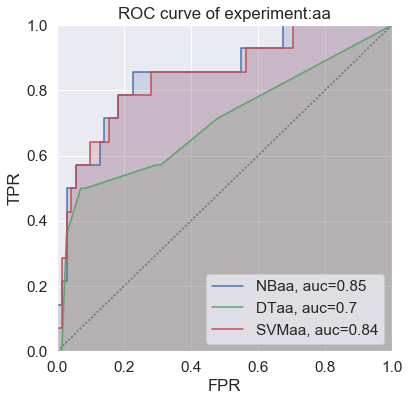

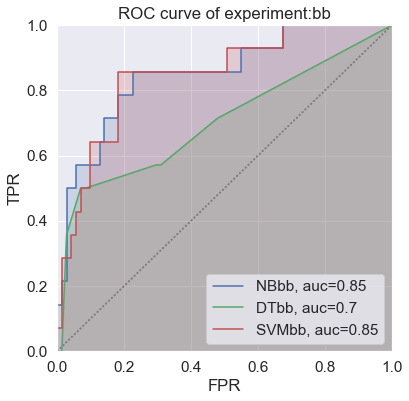

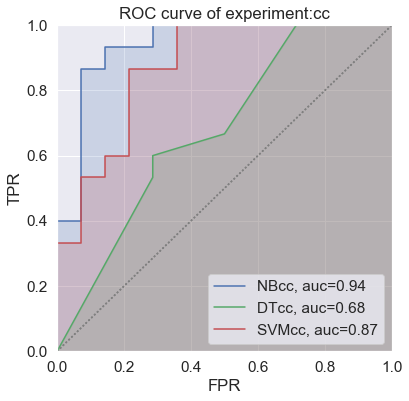

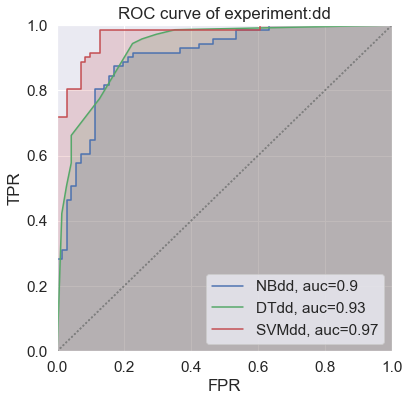

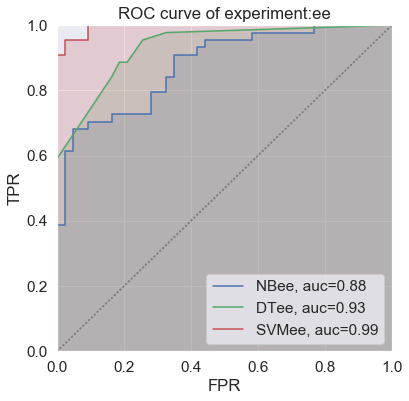

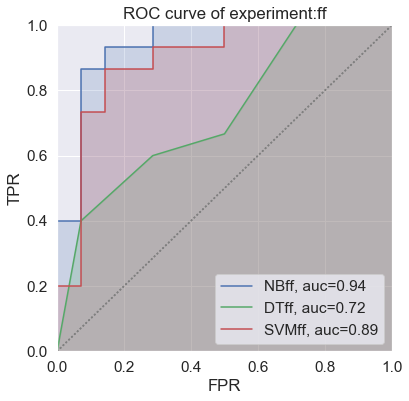

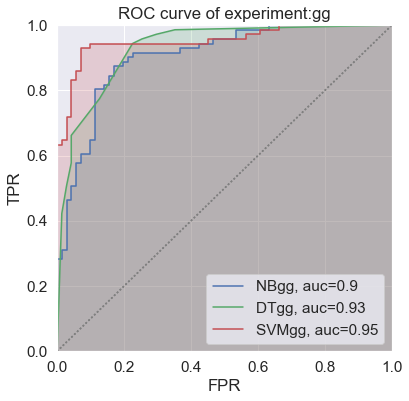

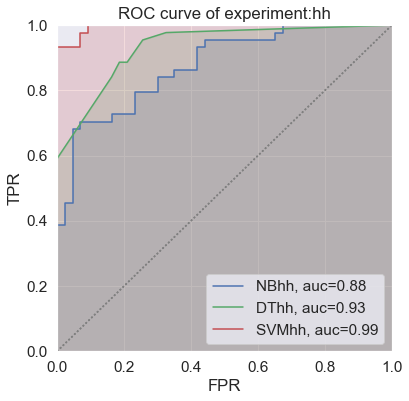

In [41]:
for i in range(len(All_data)):
    _, X_test_p, _, y_test_p = All_data[i]
    plot_roc(X_test_p, y_test_p, ALLGridSearchCV_List[i::8])

### Plot PR Curve

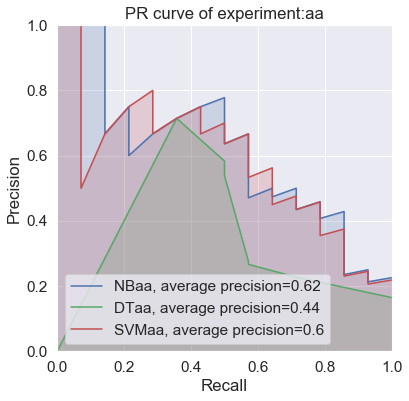

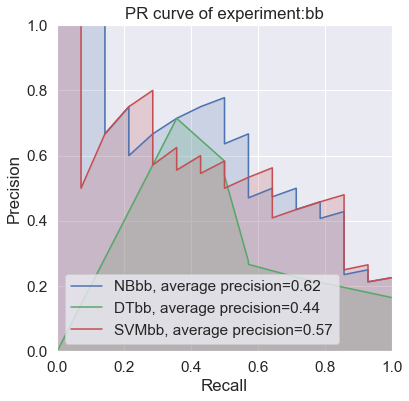

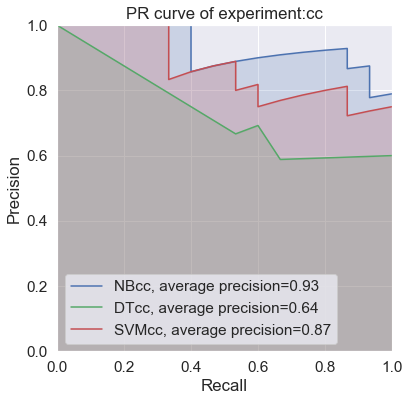

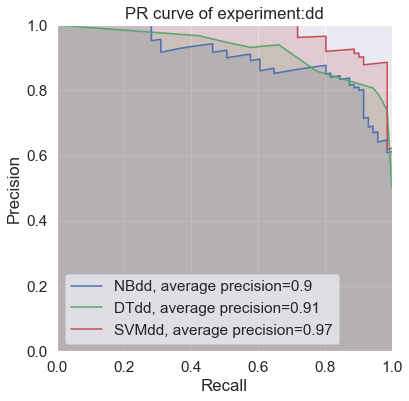

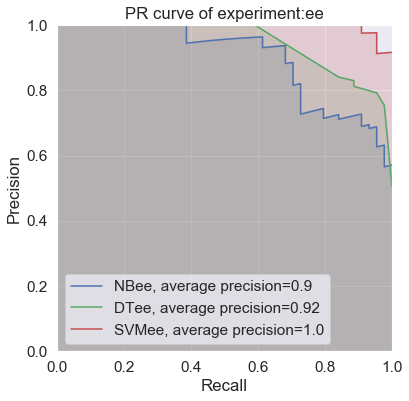

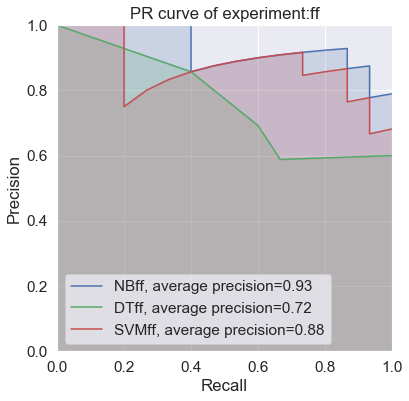

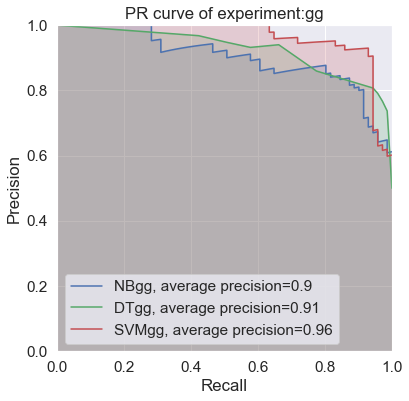

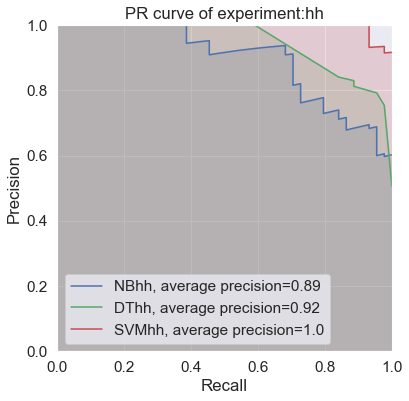

In [42]:
for i in range(len(All_data)):
    _, X_test_p, _, y_test_p = All_data[i] 
    plot_pr(X_test_p, y_test_p, ALLGridSearchCV_List[i::8])

In [4]:
# Describe all experiment
for i in Pipe_list:
    print(i,':', end="")
    describe_pipe(eval(i))

aa :Initialize --> Standardize --> Split --> Develop_Model
bb :Initialize --> Split --> Develop_Model
cc :Initialize --> Down_sampling --> Split --> Develop_Model
dd :Initialize --> Over_sampling --> Split --> Develop_Model
ee :Initialize --> Down_sampling --> Over_sampling --> Split --> Develop_Model
ff :Initialize --> Down_sampling --> Standardize --> Split --> Develop_Model
gg :Initialize --> Over_sampling --> Standardize --> Split --> Develop_Model
hh :Initialize --> Down_sampling --> Over_sampling --> Standardize --> Split --> Develop_Model


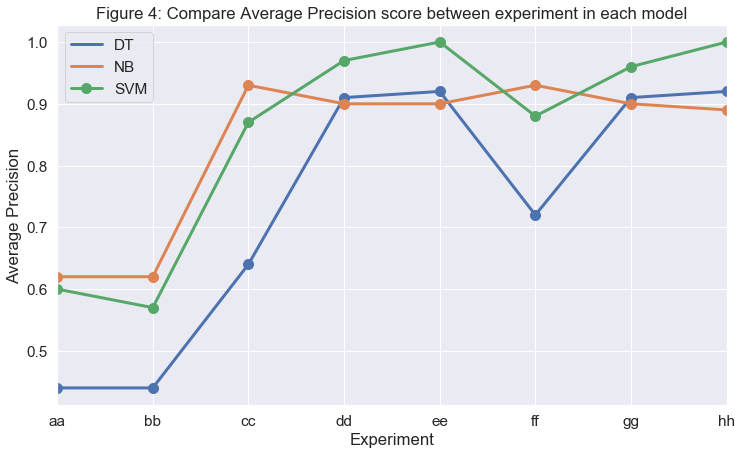

In [44]:
# Figure 4: Compare Average_Precision score between experiment in each model
title = 'Figure 4: Compare Average Precision score between experiment in each model'
df_plot = df_report_all.copy()
df_plot.set_index('Experiment', inplace=True)
ax = df_plot.groupby('Model')['Average_Precision'].plot(legend=True,figsize= (12,7),grid = True, 
                                                        marker='.', markersize=20, lw=3,
                                                        kind = 'line', title = title );
ax[0].set_ylabel("Average Precision");

### Convert all experiment model to Dict

In [45]:
def create_dict_Model(Model_list, Pipe_list):
    Dict_Collection = dict()
    for i in Model_list:
        for j in Pipe_list:
            exec('X_train, X_test, y_train, y_test = data_' + j)
            dict_name = i[:-7]+j
            exec('%s = {}' % (dict_name))
            #exec('%s["gridcv"] = %s_gs' % (dict_name,dict_name))
            exec('%s["tuned_model"] = %s_gs' % (dict_name,dict_name))
            exec('%s["train_ap_score"] = %s["tuned_model"].best_estimator_.score(X_train, y_train)' % (dict_name,dict_name))
            exec('%s["test_ap_score"] = %s["tuned_model"].best_estimator_.score(X_test, y_test)' % (dict_name,dict_name))
            exec('%s["P(dm)"] = %s["tuned_model"].best_estimator_.predict_proba(X_test)[:, 1]' % (dict_name,dict_name))
            exec('%s["y_hat"] = %s["tuned_model"].best_estimator_.predict(X_test)' % (dict_name,dict_name))
            exec('%s["confus_mat"] = confusion_matrix(y_test, %s["y_hat"], labels=[0, 1])' % (dict_name,dict_name))
            exec('%s["accuracy"] = round(accuracy_score(y_test, %s["y_hat"]), 2)' % (dict_name,dict_name))
            exec('%s["roc"] = roc_curve(y_test, %s["P(dm)"], pos_label=1)' % (dict_name,dict_name))
            exec('%s["pr"] = precision_recall_curve(y_test, %s["P(dm)"], pos_label=1)' % (dict_name,dict_name))
            exec('%s["auc"] = round(roc_auc_score(y_test, %s["P(dm)"]), 2)' % (dict_name,dict_name))
            exec('%s["ap"] = round(average_precision_score(y_test, %s["P(dm)"]), 2)' % (dict_name,dict_name))
            
            exec('Dict_Collection["%s"] = eval("%s")' % (dict_name,dict_name))
    return Dict_Collection

In [46]:
Dict_Collection = create_dict_Model(Model_list, Pipe_list)

#### Pick some model to look in detail

In [47]:
# List all available model
print("List of Experiment Model: {}".format(', '.join(Dict_Collection)))

List of Experiment Model: NBaa, NBbb, NBcc, NBdd, NBee, NBff, NBgg, NBhh, DTaa, DTbb, DTcc, DTdd, DTee, DTff, DTgg, DThh, SVMaa, SVMbb, SVMcc, SVMdd, SVMee, SVMff, SVMgg, SVMhh


In [48]:
# Create function for print out model with easier to look
def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key) + ':')
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

In [49]:
# Show model in detail
pretty(Dict_Collection['DTgg']) # You can change model mame by yourself.

tuned_model:
	GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['entropy'], 'max_depth': array([4, 5, 6, 7]), 'min_samples_split': array([0.08   , 0.08211, 0.08421, 0.08632, 0.08842, 0.09053, 0.09263,
       0.09474, 0.09684, 0.09895, 0.10105, 0.10316, 0.10526, 0.10737,
       0.10947, 0.11158, 0.11368, 0.11579, 0.11789, 0.12   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=0)
train_ap_score:
	0.8816254416961131
test_ap_score:
	0.823943661971831
P(dm):
	[1.         0.      

# Conclusion

![title](figure/SummaryExperiment_fig4.png)

### Which model is the best to solve our domain problem among all experiment? Why?
- SVM model is the best to solve our domain problem among all experiment.
- According to Figure 4, most of the highest average precision score falls in the SVM model.

###  Which experiment is the best for our domain problem for each model? Why?
- Experiment ee and hh are the best for our domain problem for each model.
- According to Figure 4, both of these experiments got the highest average precision score.

# Discussion

### Model selection
- For Naive Baye classifier due to our feature is a numerical value, thus, we will implement a classic Gaussian Naive Bayes on the sim_predm dataset.

### Imbalanced Class
- Generally, this problem deals with the trade-off between recall (percent of truly positive instances that were classified as such) and precision (percent of positive classifications that are truly positive). Thus, when comparing approaches to imbalanced classification problems, consider using metrics beyond accuracies such as recall, precision, and AUC.
- Due to we know this dataset is imbalanced class, thus, in tuning model we change the scoring from default: accuracy to average_precision that would be conformed to evaluating criteria.

### Undersampling/Oversampling

![title](figure/ImbalancedClasses_fig5.jpg)
source:https://towardsdatascience.com/breaking-the-curse-of-small-datasets-in-machine-learning-part-1-36f28b0c044d

- In practice we not do undersampling/oversampling before split data to train and test due to it would make test data be changed and undersampling/oversampling incorrectly can lead to thinking a model will generalize better or even worse than it actually does.
- On the other hand, we should do undersampling/oversampling on only the training data. By undersampling/oversampling only on the training data, none of the information in the validation data is being used to create synthetic observations. So these results should be generalizable.

### Evaluation

![title](figure/Modified-Confusion-Matrix-Table-for-Accuracy-Prediction-of-24.ppm.png)
![title](figure/Accuracy_fig.png)

- When making a prediction for a two-class classification problem, the following types of errors can be made by a classifier:
    - False Positive (FP): predict an event when there was no event.
    - False Negative (FN): predict no event when in fact there was an event.
    - True Positive (TP): predict an event when there was an event.
    - True Negative (TN): predict no event when in fact there was no event.
   

- **Accuracy:** Accuracy tell us about the overall performance of the model.

- **Recall:** Recall gives us an idea about when it’s actually yes, how often does it predict yes.

- **Precision:** Precision tells us about when it predicts yes, how often is it correct.

- **ROC Curves:** summarise the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.

- **Precision-Recall curves:** summarise the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.

*Note that in computing precision and recall there is never use of the true negatives, these measures only consider correct predictions*

- With imbalanced classes, it’s easy to get a high accuracy without actually making useful predictions. So, accuracy as an evaluation metrics makes sense only if the class labels are uniformly distributed as well as ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets. In both cases, the area under the curve (AUC) can be used as a summary of the model performance.

- As shown before when one has imbalanced classes, precision and recall are better metrics than accuracy, in the same way, for imbalanced datasets a Precision-Recall curve is more suitable than a ROC curve.

- For this sim_predm dataset, it’s better to rely on average precision which is a measure that combines recall and precision. That is the reason we use average precision to evaluate this ML experiment. 





